# Solution

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

cordic_gain = 1.64676

## Polar to Rectangular


In [2]:
!make clean
!make cordic_ptor.csv

rm -f cordic_ptor.csv cordic_rtop.csv cordic.pdf cordic_solution.pdf cordicg_b22.v
python cordicgx.py 22 > cordicg_b22.v
iverilog -P cordicg_tb.width=18			 -P cordicg_tb.nstg=20		 -Wall -Wno-timescale -o cordicg_tb cordicg_tb.v cordicg_b22.v cstageg.v addsubg.v
vvp -N cordicg_tb +op=0 +of=cordic_ptor.csv
Recording output to file:      cordic_ptor.csv
width =   18, nstg =   20


In [3]:
DW = 18
full_scale = (1 << DW)

In [4]:
df = pd.read_csv('cordic_ptor.csv', skipinitialspace=True)
df.set_index('T [ns]')

,phasein,xin,yin,xout,yout,phaseout
T [ns],,,,,,
10,0,0,0,0,0,0
30,0,0,0,0,0,0
50,0,0,0,0,0,0
70,0,0,0,0,0,0
90,0,0,0,0,0,0
...,...,...,...,...,...,...
159910,-101666,54272,7943,43124,-79366,0
159930,-101613,54272,7944,43176,-79338,0
159950,-101560,54272,7945,43228,-79309,0


In [5]:
theta = np.pi / full_scale * df['phasein']

In [6]:
df['xcheck'] = df['xin'] * np.cos(theta) - df['yin'] * np.sin(theta)
df['ycheck'] = df['xin'] * np.sin(theta) + df['yin'] * np.cos(theta)
df['xerror'] = (df['xcheck'] * cordic_gain) - df['xout']
df['yerror'] = (df['ycheck'] * cordic_gain) - df['yout']

In [7]:
err_p2p = df['xerror'].max() - df['xerror'].min()
err_rms = df['xerror'].std()
print(f'xout peak-to-peak error: {err_p2p:.3f} cnt, {err_p2p / full_scale * 100:.4f} %')
print(f'xout rms error:          {err_rms:.3f} cnt, {err_rms / full_scale * 100:.4f} %')

xout peak-to-peak error: 2.297 cnt, 0.0009 %
xout rms error:          0.358 cnt, 0.0001 %


In [8]:
df[['xerror', 'yerror']].describe()

,xerror,yerror
count,8000.000000,8000.000000
mean,-0.021085,-0.018349
std,0.358344,0.355289
min,-1.254179,-1.113595
25%,-0.281462,-0.276111
50%,-0.020349,-0.020113
75%,0.239083,0.241177
max,1.043313,1.102332


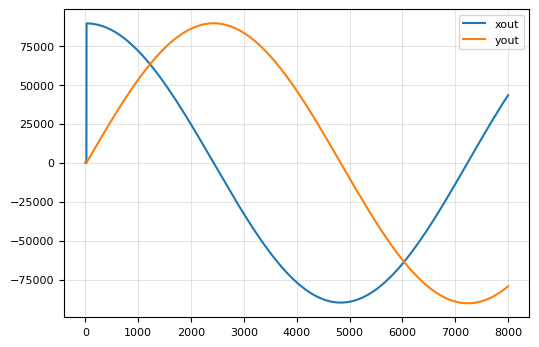

In [9]:
df[['xout', 'yout']].plot();

## Rectangular to Polar

In [10]:
!make clean
!make cordic_rtop.csv

rm -f cordic_ptor.csv cordic_rtop.csv cordic.pdf cordic_solution.pdf cordicg_b22.v
python cordicgx.py 22 > cordicg_b22.v
iverilog -P cordicg_tb.width=18			 -P cordicg_tb.nstg=20		 -Wall -Wno-timescale -o cordicg_tb cordicg_tb.v cordicg_b22.v cstageg.v addsubg.v
vvp -N cordicg_tb +op=1 +of=cordic_rtop.csv
Recording output to file:      cordic_rtop.csv
width =   18, nstg =   20


In [11]:
df = pd.read_csv('cordic_rtop.csv', skipinitialspace=True)
df.set_index('T [ns]')

,phasein,xin,yin,xout,yout,phaseout
T [ns],,,,,,
10,0,0,0,0,0,0
30,0,0,0,0,0,0
50,0,0,0,0,0,0
70,0,0,0,0,0,0
90,0,0,0,0,0,0
...,...,...,...,...,...,...
159910,0,-61893,9244,103054,0,249773
159930,0,-61909,9123,103051,0,249935
159950,0,-61924,9002,103046,0,250098


In [12]:
theta = np.arctan2(df['yin'], df['xin'])
# rotate negative theta from [-pi, 0] to [pi, 2pi]
theta[theta<0] += 2 * np.pi
# scale to counts
theta *= full_scale / np.pi
# Add error array
df['perror'] = theta - df['phaseout']
df['rerror'] = df['xout'] / cordic_gain - np.hypot(df['xin'], df['yin'])

In [13]:
err_p2p = df['perror'].max() - df['perror'].min()
err_rms = df['perror'].std()
print(f'pout peak-to-peak error: {err_p2p:.3f} cnt, {err_p2p / full_scale * 100:.4f} %')
print(f'pout rms error:          {err_rms:.3f} cnt, {err_rms / full_scale * 100:.4f} %')

pout peak-to-peak error: 2.033 cnt, 0.0008 %
pout rms error:          0.362 cnt, 0.0001 %


In [14]:
err_p2p = df['rerror'].max() - df['rerror'].min()
err_rms = df['rerror'].std()
print(f'rout peak-to-peak error: {err_p2p:.3f} cnt, {err_p2p / full_scale * 100:.4f} %')
print(f'rout rms error:          {err_rms:.3f} cnt, {err_rms / full_scale * 100:.4f} %')

rout peak-to-peak error: 1.012 cnt, 0.0004 %
rout rms error:          0.192 cnt, 0.0001 %


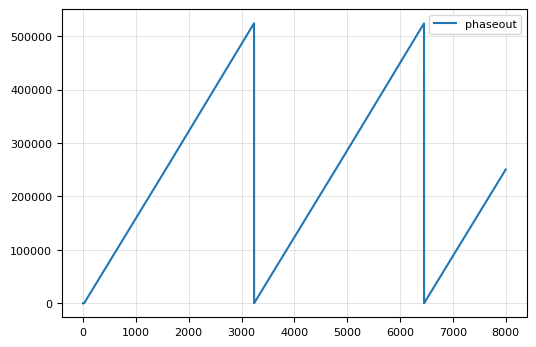

In [15]:
df[['phaseout']].plot();

## Change data width, test Polar to Rectangular


In [16]:
!make clean
!make cordic_ptor.csv DW=20

rm -f cordic_ptor.csv cordic_rtop.csv cordic.pdf cordic_solution.pdf cordicg_b22.v
python cordicgx.py 22 > cordicg_b22.v
iverilog -P cordicg_tb.width=20 -P cordicg_tb.nstg=20		 -Wall -Wno-timescale -o cordicg_tb cordicg_tb.v cordicg_b22.v cstageg.v addsubg.v
vvp -N cordicg_tb +op=0 +of=cordic_ptor.csv
Recording output to file:      cordic_ptor.csv
width =   20, nstg =   20


In [17]:
DW = 20
full_scale = (1 << DW)

In [18]:
df = pd.read_csv('cordic_ptor.csv', skipinitialspace=True)
df.set_index('T [ns]');

In [19]:
theta = np.pi / full_scale * df['phasein']
df['xcheck'] = df['xin'] * np.cos(theta) - df['yin'] * np.sin(theta)
df['ycheck'] = df['xin'] * np.sin(theta) + df['yin'] * np.cos(theta)
df['xerror'] = (df['xcheck'] * cordic_gain) - df['xout']
df['yerror'] = (df['ycheck'] * cordic_gain) - df['yout']

In [20]:
err_p2p = df['xerror'].max() - df['xerror'].min()
err_rms = df['xerror'].std()
print(f'xout peak-to-peak error: {err_p2p:.3f} cnt, {err_p2p / full_scale * 100:.4f} %')
print(f'xout rms error:          {err_rms:.3f} cnt, {err_rms / full_scale * 100:.4f} %')

xout peak-to-peak error: 6.300 cnt, 0.0006 %
xout rms error:          0.806 cnt, 0.0001 %


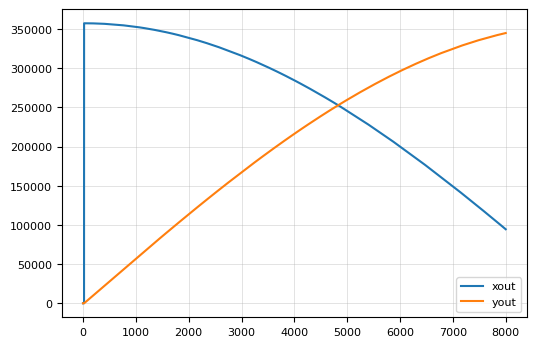

In [21]:
df[['xout', 'yout']].plot();

## Change pipeline stage, test Polar to Rectangular


In [22]:
!make clean
!make cordic_ptor.csv NSTG=22 DW=19

rm -f cordic_ptor.csv cordic_rtop.csv cordic.pdf cordic_solution.pdf cordicg_b22.v
python cordicgx.py 22 > cordicg_b22.v
iverilog -P cordicg_tb.width=19 -P cordicg_tb.nstg=22 -Wall -Wno-timescale -o cordicg_tb cordicg_tb.v cordicg_b22.v cstageg.v addsubg.v
vvp -N cordicg_tb +op=0 +of=cordic_ptor.csv
Recording output to file:      cordic_ptor.csv
width =   19, nstg =   22


In [28]:
DW = 19
full_scale = (1 << DW)

In [29]:
df = pd.read_csv('cordic_ptor.csv', skipinitialspace=True)
df.set_index('T [ns]');

In [30]:
theta = np.pi / full_scale * df['phasein']
df['xcheck'] = df['xin'] * np.cos(theta) - df['yin'] * np.sin(theta)
df['ycheck'] = df['xin'] * np.sin(theta) + df['yin'] * np.cos(theta)
df['xerror'] = (df['xcheck'] * cordic_gain) - df['xout']
df['yerror'] = (df['ycheck'] * cordic_gain) - df['yout']

In [31]:
err_p2p = df['xerror'].max() - df['xerror'].min()
err_rms = df['xerror'].std()
print(f'xout peak-to-peak error: {err_p2p:.3f} cnt, {err_p2p / full_scale * 100:.4f} %')
print(f'xout rms error:          {err_rms:.3f} cnt, {err_rms / full_scale * 100:.4f} %')

xout peak-to-peak error: 2.985 cnt, 0.0006 %
xout rms error:          0.435 cnt, 0.0001 %


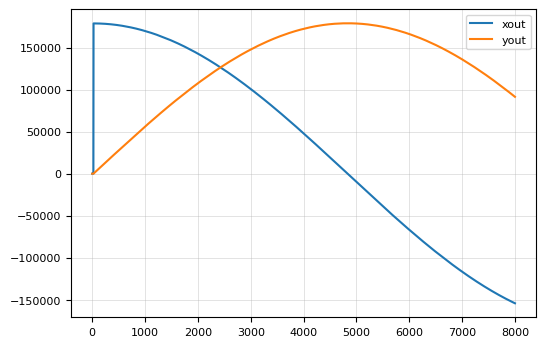

In [32]:
df[['xout', 'yout']].plot();